<a href="https://colab.research.google.com/github/RishabhL7/Model_Comparison/blob/main/HGR_Net_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import matplotlib.pyplot as plt
import keras
from tqdm import tqdm

In [2]:
!nvidia-smi

Fri Mar 11 16:32:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [5]:
!unzip '/content/drive/MyDrive/Data.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Data/hand_data_test/segmentation/A-aha-0004.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0005.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0006.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0007.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0008.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0009.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0010.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0001.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0002.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0003.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0004.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0005.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0006.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0007.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0008.png  
 ext

In [6]:
path = "//content/Data/hand_data_train/colour"
maskpath = "/content/Data/hand_data_train/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:04<00:00, 434.01it/s]


In [7]:
path = "/content/Data/hand_data_test/colour"
maskpath = "/content/Data/hand_data_test/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:02<00:00, 433.15it/s]


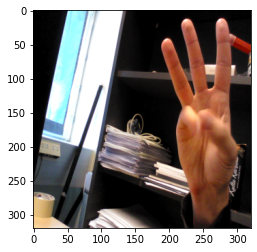

In [8]:
plt.imshow(array_to_img(X_train[0]))

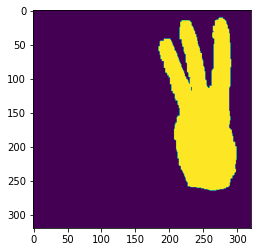

In [9]:
plt.imshow(array_to_img(Y_train[0]))

In [10]:
print(X_train.shape, Y_train.shape)

(2000, 320, 320, 3) (2000, 320, 320, 1)


In [12]:
# Defining the Segmentation Model



class SegModel(object):
        def __init__(self, input_size):
            self.input_size=input_size
            self._build_model()
            

        def relu(self,x):
            return Activation('relu')(x)

        def ResidualNet(self,filters,s):
            def Res_unit(x):
              BottleN = int(filters / 4)
              b_filter = BottleN

              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)
              ident_map = x

              x = Conv2D(filters=b_filter, kernel_size=(1, 1), strides=(s, s))(x)
              
              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)

              x = Conv2D(filters=b_filter, kernel_size=(3, 3),  padding="same")(x)

              x = BatchNormalization(axis=-1)(x)
              x = Activation("relu")(x)

              x = Conv2D(filters=filters, kernel_size=(1,1))(x)

              ident_map = Conv2D(filters,(1,1),strides=(s,s))(ident_map)
              
              out = keras.layers.add([ident_map,x])

              return out
            return Res_unit

        def Res_Group(self,nfilter,layers,_stride):
            def Res_unit(x):
                for i in range(layers):
                    if i==0:
                        x = self.ResidualNet(nfilter,_stride)(x)
                    else:
                        x = self.ResidualNet(nfilter,1)(x)
                                   
                              
                return x
            return Res_unit

        #-------------------Pyramid Dilated Convolution--------------------------------
        def ASPP(self,input_layer):
            l = BatchNormalization(axis=-1)(input_layer)
            l = self.relu(l)
            conv1 = l
            dconv_filters=32
            a1 = Conv2D(dconv_filters, 1, activation = 'relu', padding = 'same', dilation_rate = 1)(conv1)
            a2 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 3)(conv1)
            a3 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 6)(conv1)
            a4 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 12)(conv1)
            a5 = Conv2D(dconv_filters, 3, activation = 'relu', padding = 'same', dilation_rate = 18)(conv1)

            concat = keras.layers.concatenate([a1,a2,a3,a4,a5], axis = 3)  
            
            return concat


        def _build_model(self):
        #--------------------encoder---------    
            inp = Input(shape=(self.input_size))
            i = inp
            i = Conv2D(16,7,padding='same')(i)
        #----------------------------------------
            i = self.Res_Group(32,3,1)(i) 
        #----------------------------------------
            i = self.Res_Group(64,3,2)(i) 
        #---------------------------------------
            i = self.Res_Group(128,3,2)(i) 
            out_pdc2 = self.ASPP(i)
        #---------------------------------------

        #-----------------------decoder----------------
            i_dec = Dropout(0.15)(out_pdc2)

            conv_f = Conv2D(1,(1, 1), activation='sigmoid', padding='same')(i_dec)

            i_dec=keras.layers.UpSampling2D(size = (4,4), interpolation='bilinear')(conv_f)



            model = Model(inputs=inp, outputs=i_dec )

            self.model=model

In [18]:
HGR_net = SegModel((320,320,3))
model = HGR_net.model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_129 (Conv2D)            (None, 320, 320, 16  2368        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 320, 320, 16  64         ['conv2d_129[0][0]']             
 ormalization)                  )                                                           

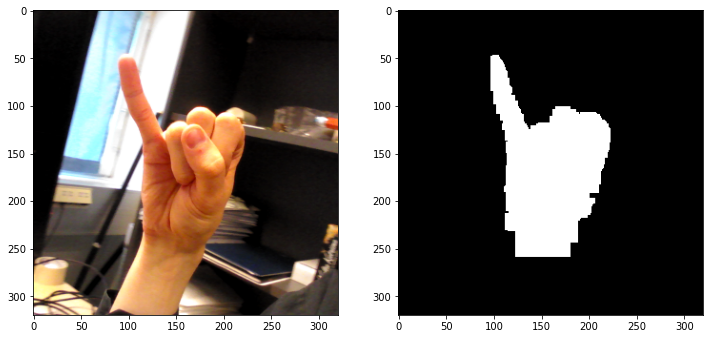

In [19]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(array_to_img(Y_train[image_number]), cmap='gray')
plt.show()

In [20]:
from tensorflow.keras.optimizers import Adam

In [21]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [22]:
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef, iou, "accuracy"])

In [ ]:
!pip install keras-flops

In [24]:
from keras_flops import get_flops
flops = get_flops(model, batch_size=16)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 1e+02 G


In [25]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/HGR-Net_500"
os.mkdir(path)

In [26]:
checkpoint_path_segmentdeeplab = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/HGR-Net_500/cp.ckpt"
model_checkpoint_segmentdeeplab = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentdeeplab,
                                                                     save_weights_only=True,
                                                                     monitor='val_iou',
                                                                     mode="max",
                                                                     save_best_only=True,
                                                                     verbose=1)

In [27]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=16, epochs=500, callbacks=[model_checkpoint_segmentdeeplab])

Epoch 1/500
125/125 [==============================] - ETA: 0s - loss: 0.4496 - dice_coef: 0.5504 - iou: 0.4064 - accuracy: 0.7576
Epoch 1: val_iou improved from -inf to 0.00832, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/HGR-Net_500/cp.ckpt
125/125 [==============================] - 59s 344ms/step - loss: 0.4496 - dice_coef: 0.5504 - iou: 0.4064 - accuracy: 0.7576 - val_loss: 0.9835 - val_dice_coef: 0.0165 - val_iou: 0.0083 - val_accuracy: 0.8844
Epoch 2/500
125/125 [==============================] - ETA: 0s - loss: 0.2277 - dice_coef: 0.7723 - iou: 0.6304 - accuracy: 0.9497
Epoch 2: val_iou improved from 0.00832 to 0.21343, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/HGR-Net_500/cp.ckpt
125/125 [==============================] - 41s 330ms/step - loss: 0.2277 - dice_coef: 0.7723 - iou: 0.6304 - accuracy: 0.9497 - val_loss: 0.6743 - val_dice_coef: 0.3279 - val_iou: 0.2134 - val_accuracy: 0.9049
Epoch 3/500
125/125 [==============

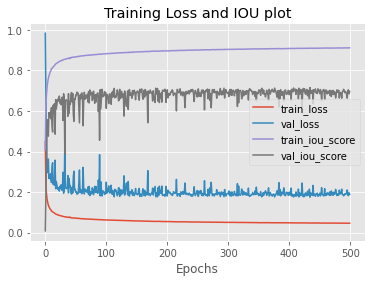

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 500
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), history.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epochs")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

Text(0, 0.5, 'Accuracy')

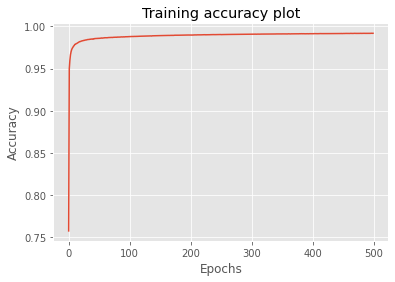

In [29]:
plt.plot(np.arange(0,N), history.history["accuracy"])
plt.title("Training accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

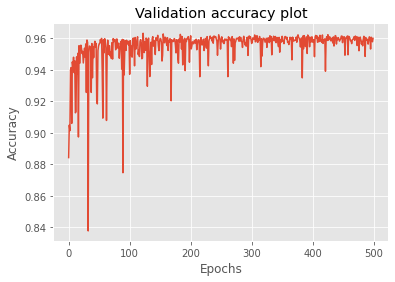

In [30]:
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

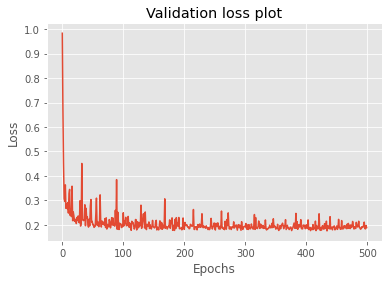

In [31]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

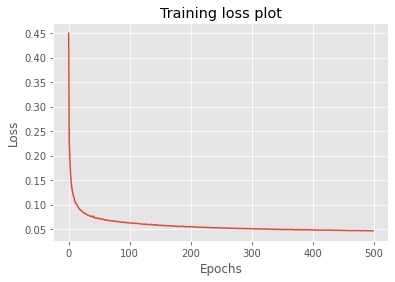

In [32]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [33]:
model.save('/content/drive/MyDrive/Colab Notebooks/HGR-Net.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/HGR-Net.h5')

In [34]:
y_pred=model.predict(X_test)

In [35]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7052774840161663


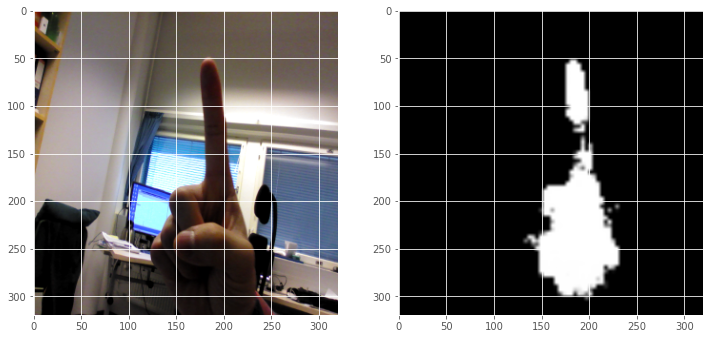

In [36]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

In [37]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/HGR-Net_500/cp.ckpt')
y_pred=model.predict(X_test)

In [38]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.7205677721233134


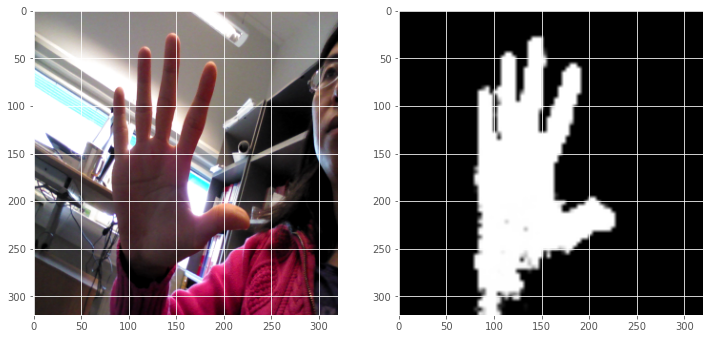

In [39]:
 #Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()